#### Libraries

In [2]:
import base64
import cv2
import openai
import os
import requests
import time

from IPython.display import display, Image, Audio
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip, AudioFileClip


### Cut original video

In [27]:
# cut video from 29 to 65
ffmpeg_extract_subclip("all_video.mp4", 29, 65, targetname="video.mp4")

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


### Read and resize video to 512x512 to avoid exceeding OpenAI token limit

In [28]:
video = cv2.VideoCapture("video.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    # resize to 512x512
    frame = cv2.resize(frame, (512,512))
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

1081 frames read.


### Check if video is ok

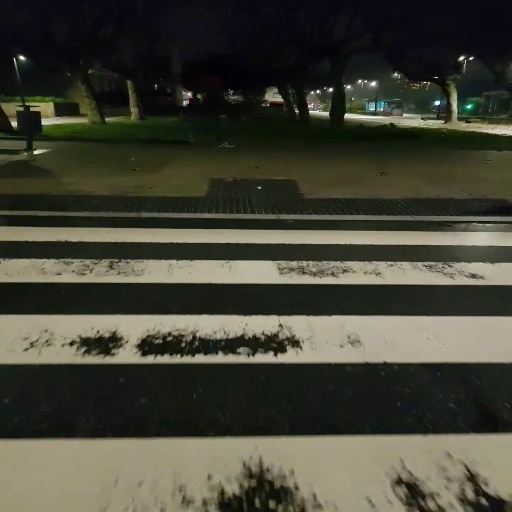

In [29]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

### Send video and prompt to GPT-4V(ision) using OpenAI API

In [52]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a person walking. Narrate succinctly with short sentences like they do in GPS devices the elements and obstacles around you to help a blind person go through.",
            *map(lambda x: {"image": x}, base64Frames[0::100]),
        ],
    },
]

params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ['OPENAI_API_KEY'],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 350,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

Sidewalk ahead, wooden boards, wet surface, veer right to avoid road.
Continue straight on the sidewalk, clear path.
Keep moving straight, watch for potential sign protruding on right.
Sidewalk continues, sign on right side, maintain straight path.
Proceed straight, sidewalk clear, buildings on right.
Approaching passageway, textured ground, stay centered.
In passageway, continue straight, follow the tactile paving.
Continue through passageway, tactile ground guidance.
Exiting passageway, prepare to navigate open space ahead.
Approaching crosswalk, wet surface, caution with potentially slippery area.



Walk straight on a textured pathway, keep the building to your right.
Continue forward with slight curve to the right.
Stay straight, small overhang ahead on your right.
Proceed, passing the overhang, continue on flat path.
Straight ahead, approaching a well-lit area.
After well-lit area, transition onto patterned pavement.
Follow the tiled pavement with guiding lines straight ahead.
Continue under the passageway, keeping the pillars parallel to you.
Move through passageway, slight descent ahead.
Pathway ends, prepare to stop at pedestrian crossing.
Stand at crosswalk, wait for audible signal to cross the street.


### Create audio based on the GPT-4V(ision) output

In [47]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "fable",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

with open('audio.mp3', 'wb') as file:
    file.write(audio)

### Join together audio and video and save final clip

In [48]:
# Open the video and audio
video_clip = VideoFileClip("video.mp4")
audio_clip = AudioFileClip("audio.mp3")

# Concatenate the video clip with the audio clip
final_clip = video_clip.set_audio(audio_clip)

# save final video
final_clip.write_videofile("video_audio.mp4")

Moviepy - Building video video_audio4.mp4.
MoviePy - Writing audio in video_audio4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video_audio4.mp4



Moviepy - Done !
Moviepy - video ready video_audio4.mp4
